# Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [2]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [3]:
mobile_sales.dtypes

DATE     datetime64[ns]
Sales           float64
dtype: object

In [4]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

In [5]:
mobile_sales.DATE.describe()

/var/folders/pb/lctdnpp509v1l7y5t98dvxj00000gn/T/ipykernel_4508/20359885.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mobile_sales.DATE.describe()


count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [7]:
18*12 + 1

217

In [8]:
mobile_sales.columns

Index(['DATE', 'Sales'], dtype='object')

In [9]:
mobile_sales.set_index('DATE', inplace=True)

In [10]:
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


<AxesSubplot:xlabel='DATE'>

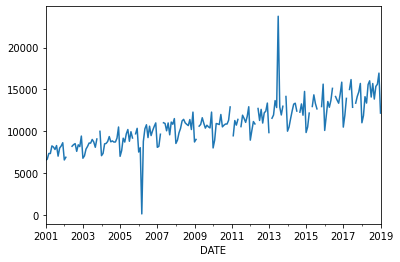

In [11]:
mobile_sales.Sales.plot()

In [12]:
mobile_sales.Sales.mean()

10842.757575757576

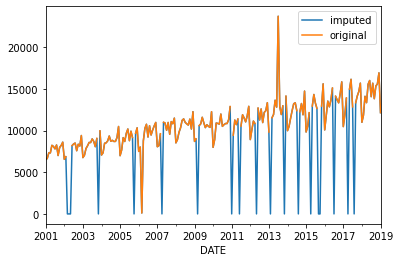

In [13]:
mobile_sales.Sales.fillna(0).plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

### Linear interpolation

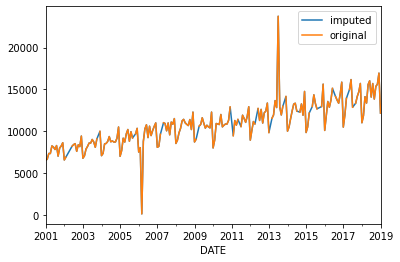

In [14]:
mobile_sales.Sales.interpolate(method='linear').plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()


In [15]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

[]

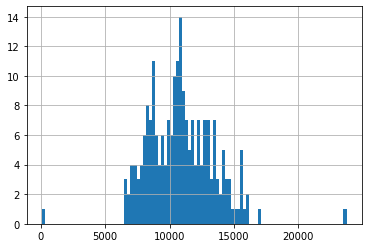

In [16]:
mobile_sales.Sales.hist(bins=100).plot()

In [17]:
mobile_sales.Sales.quantile(0.995)

16879.15999999999

In [18]:
mobile_sales.Sales.quantile(0.005)

6522.12

In [19]:
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99), lower=mobile_sales.Sales.quantile(0.01))

<AxesSubplot:xlabel='DATE'>

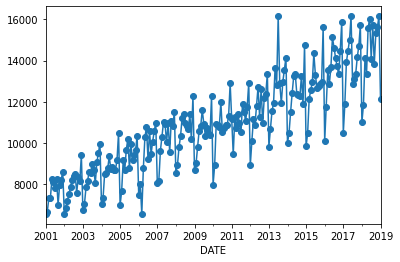

In [20]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.set_index('DATE', inplace=True)
mobile_sales.Sales = mobile_sales.Sales.interpolate()
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99), lower=mobile_sales.Sales.quantile(0.01))
mobile_sales.Sales.plot(style='-o')

<AxesSubplot:xlabel='DATE'>

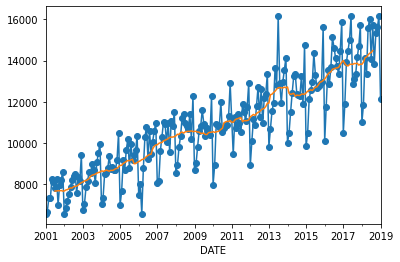

In [21]:
mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(12, center=True).mean().plot()
# mobile_sales.Sales.rolling(12, center=False).mean().plot()

### Decomposition

In [56]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

In [57]:
plt.rcParams['figure.figsize'] = (20, 10)

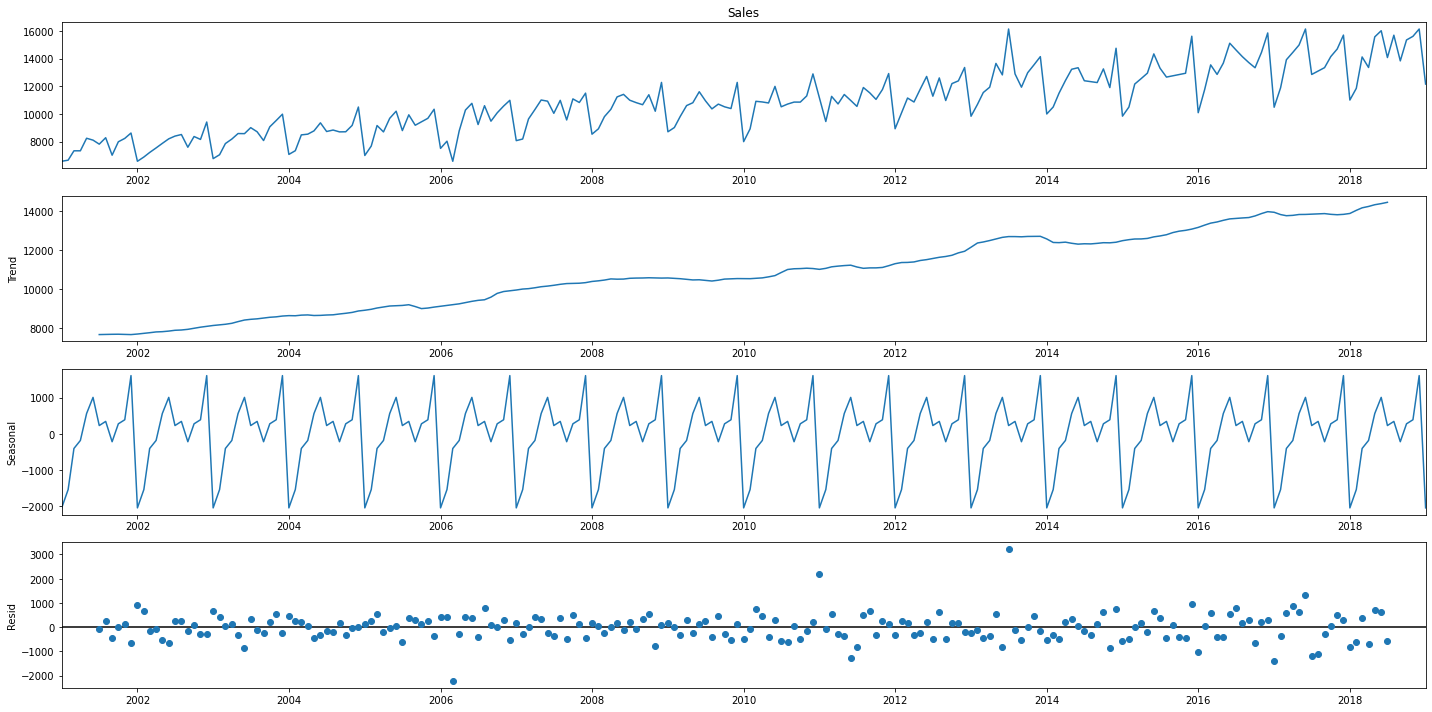

In [58]:
model.plot();

<AxesSubplot:xlabel='DATE'>

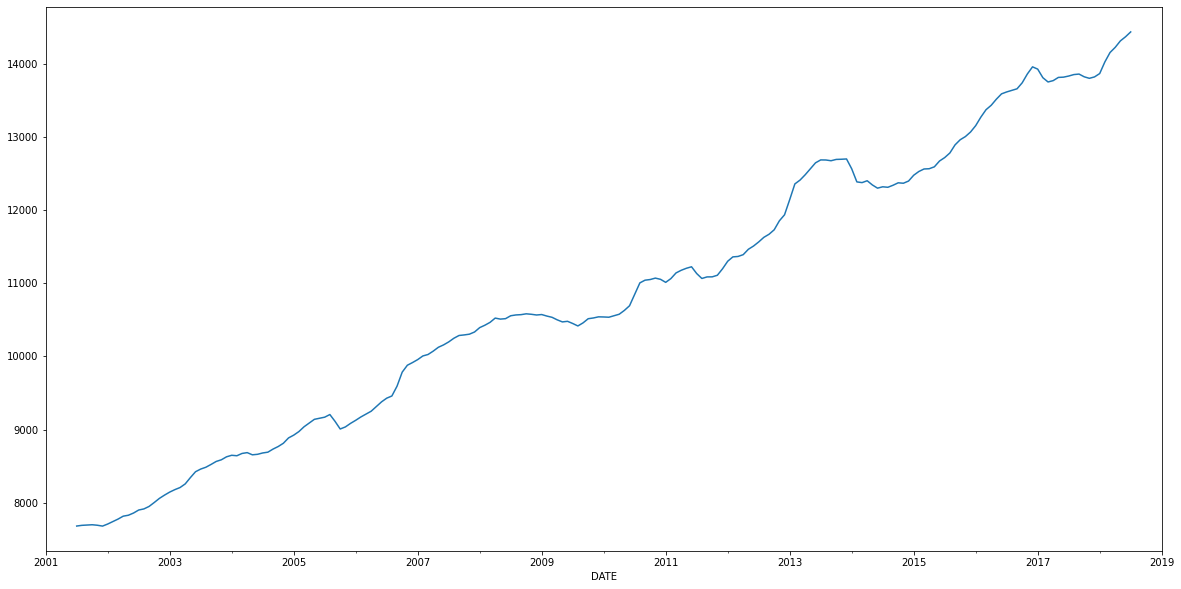

In [31]:
model.trend.plot()

### Decomposition from Scratch

**Trend_temp**

<AxesSubplot:xlabel='DATE'>

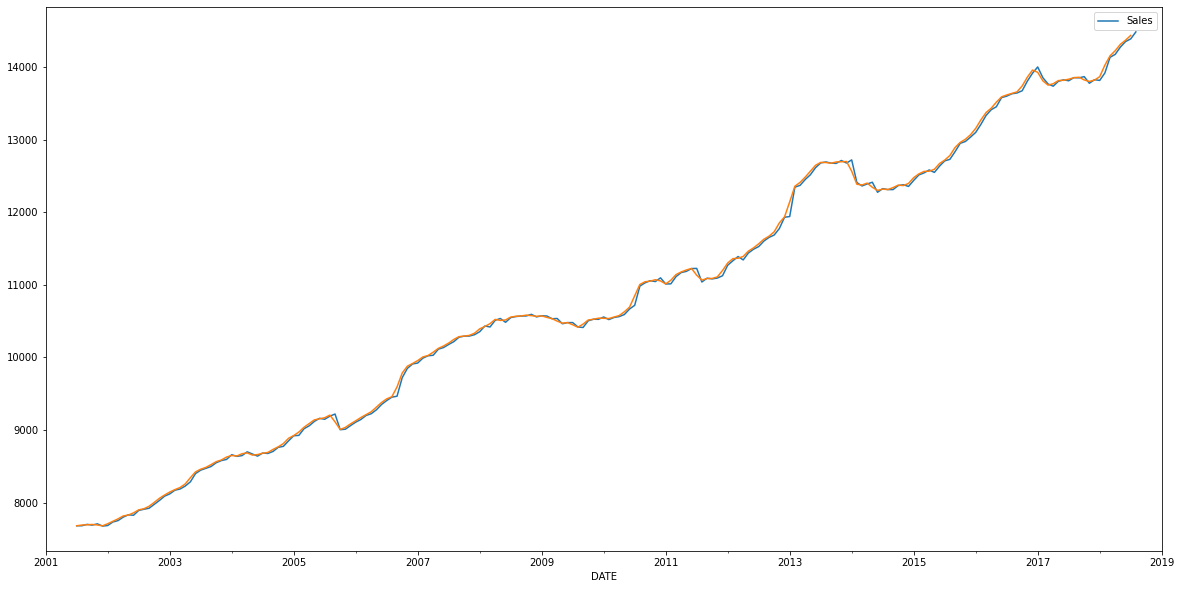

In [67]:
trend = mobile_sales.rolling(12, center=True).mean()
trend.plot()
model.trend.plot()

<AxesSubplot:xlabel='DATE'>

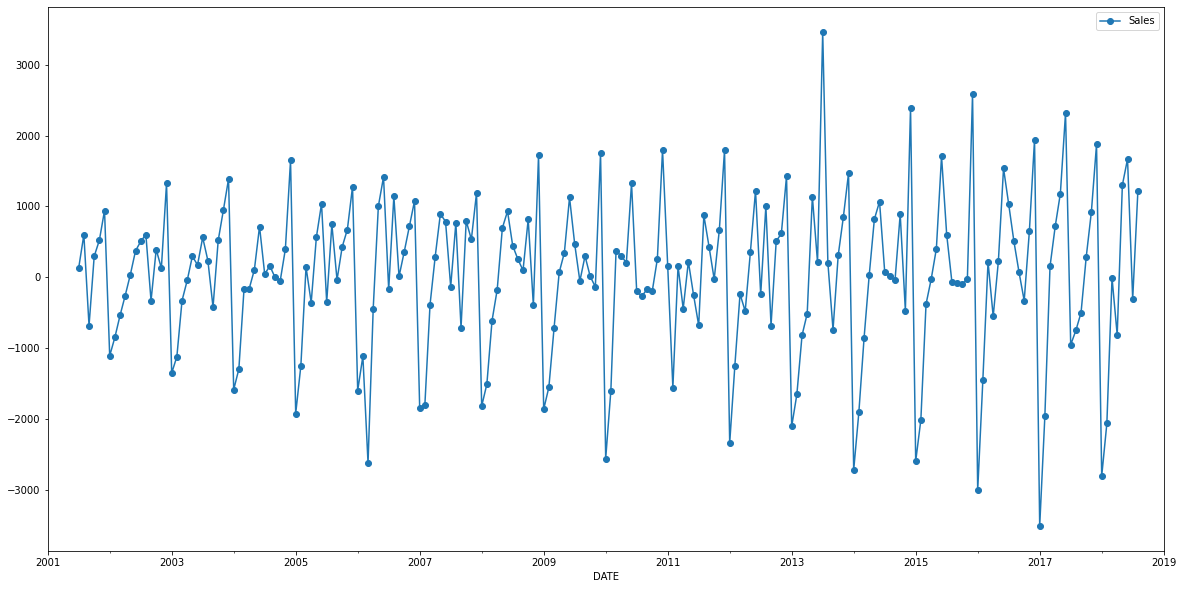

In [68]:
de_trend = mobile_sales - trend
de_trend.plot(style='-o')

<AxesSubplot:xlabel='DATE'>

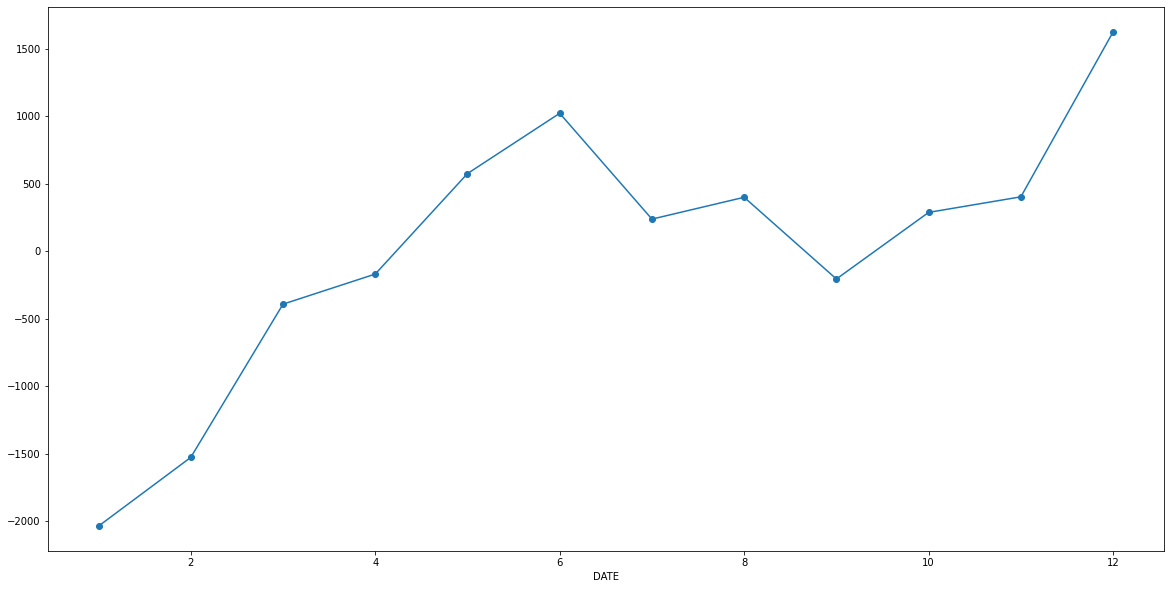

In [69]:
dtf = de_trend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

<AxesSubplot:xlabel='DATE'>

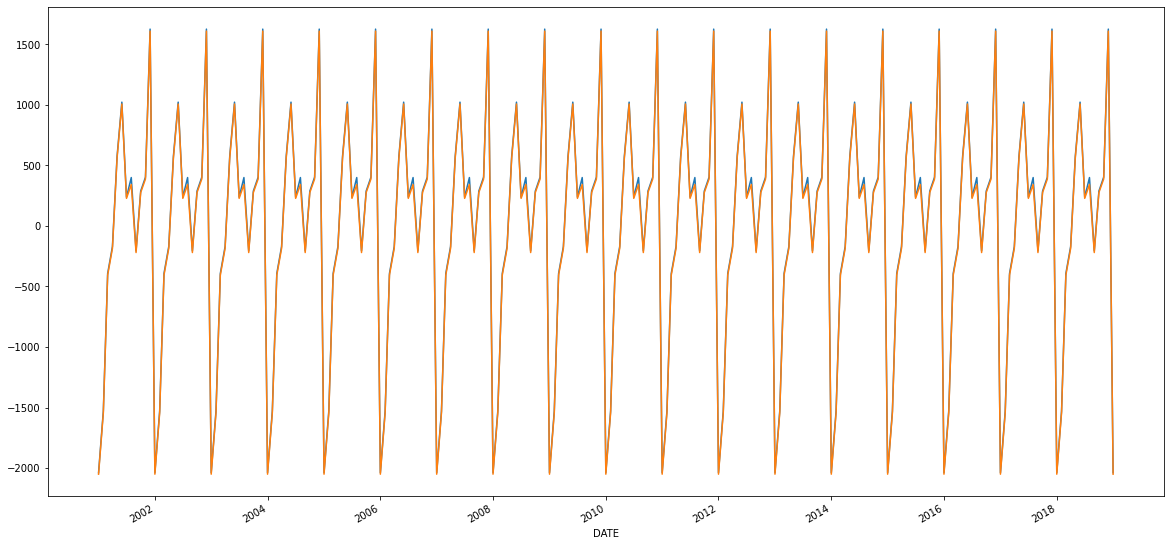

In [70]:
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'))
model.seasonal.plot()

<AxesSubplot:>

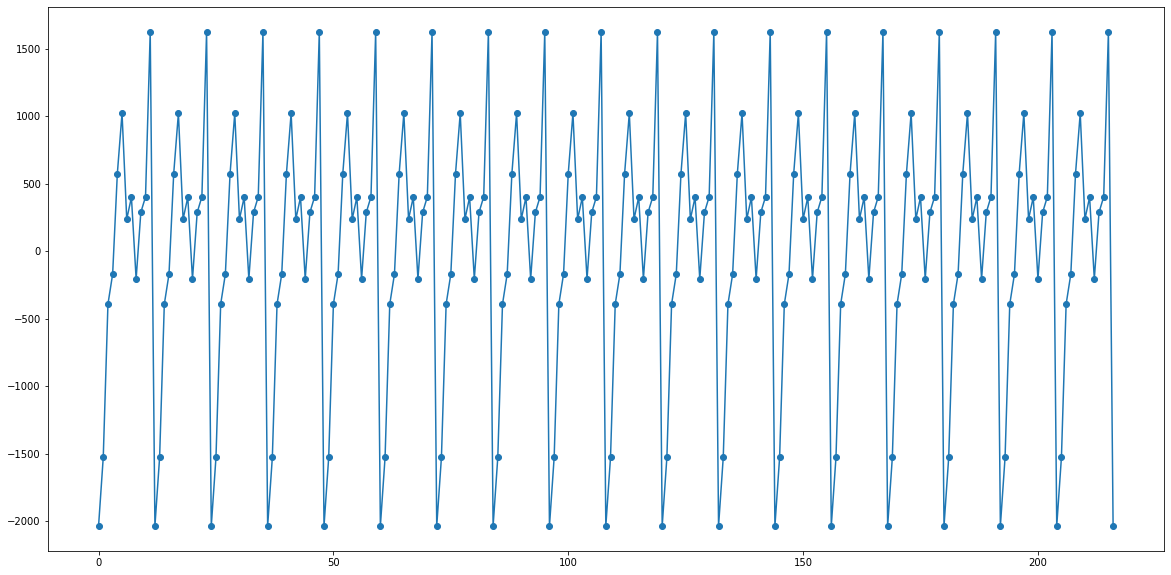

In [71]:
dtf['season'] = dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean')
dtf['season'].plot(style='-o')

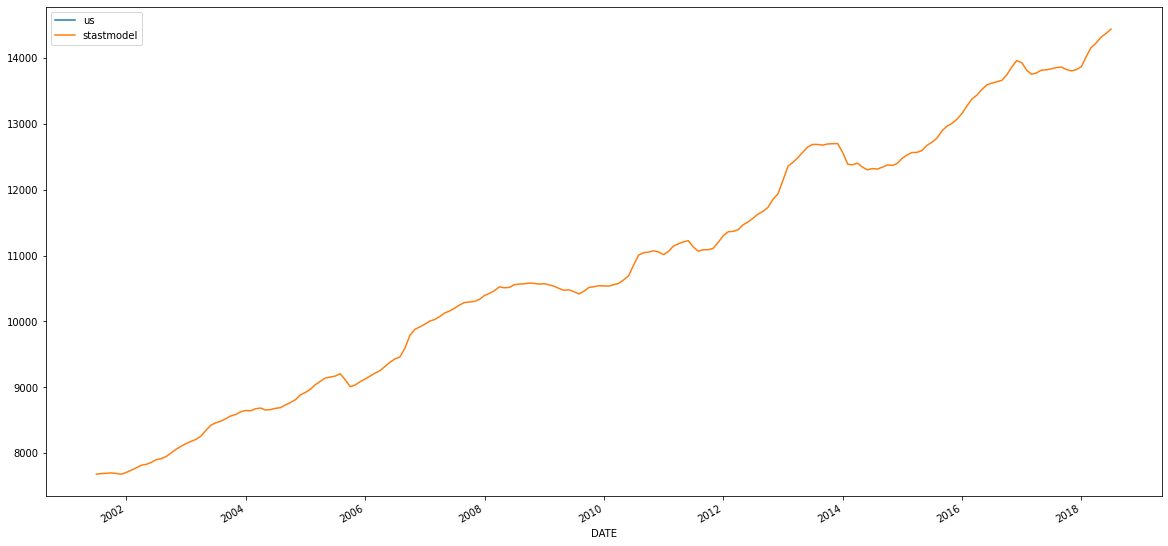

In [75]:
trend_2 = pd.Series((mobile_sales.values[:, 0] - dtf['season']).rolling(12, center=True).mean(), index=model.trend.index)
plt.plot(trend_2, label='us')
model.trend.plot(label='stastmodel')
plt.legend()

----

# Simple Forecasting Methods

In [82]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [85]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

,Sales
DATE,
2018-02-01,11852.00
2018-03-01,14123.00
2018-04-01,13360.00
2018-05-01,15576.00
2018-06-01,16021.00
2018-07-01,14080.00
2018-08-01,15697.00
2018-09-01,13838.00
2018-10-01,15351.00


### Niave Mehtod

MAE : 3479.79
RMSE : 3757.483
MAPE: 0.232


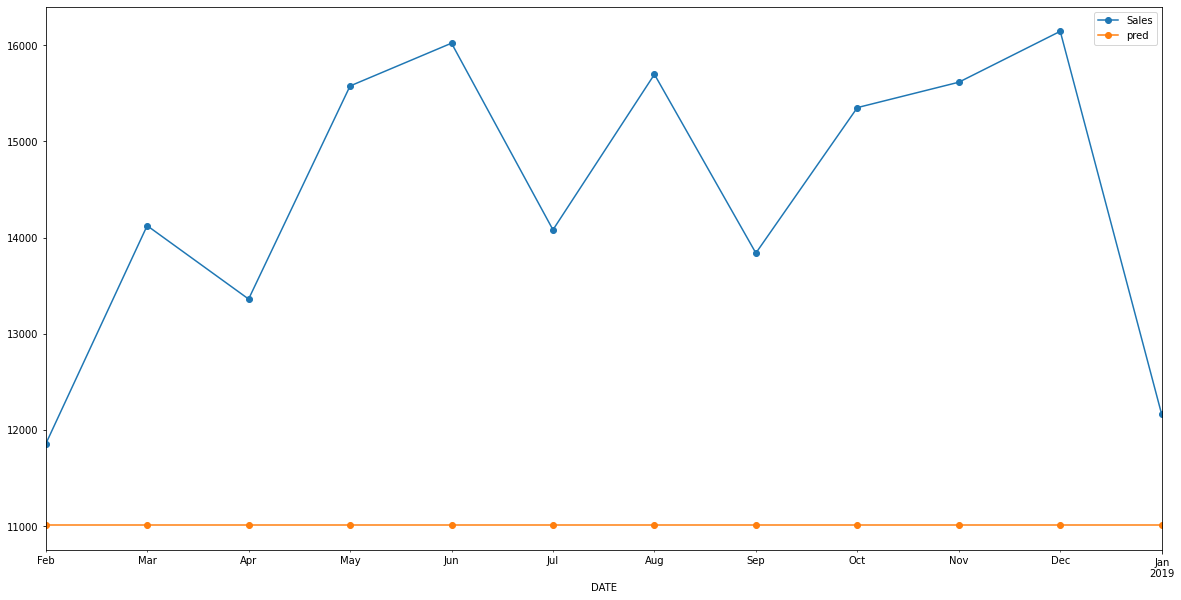

In [87]:
test_x['pred'] = train_x['Sales'][-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Mean method

MAE : 3832.336
RMSE : 4086.14
MAPE: 0.257


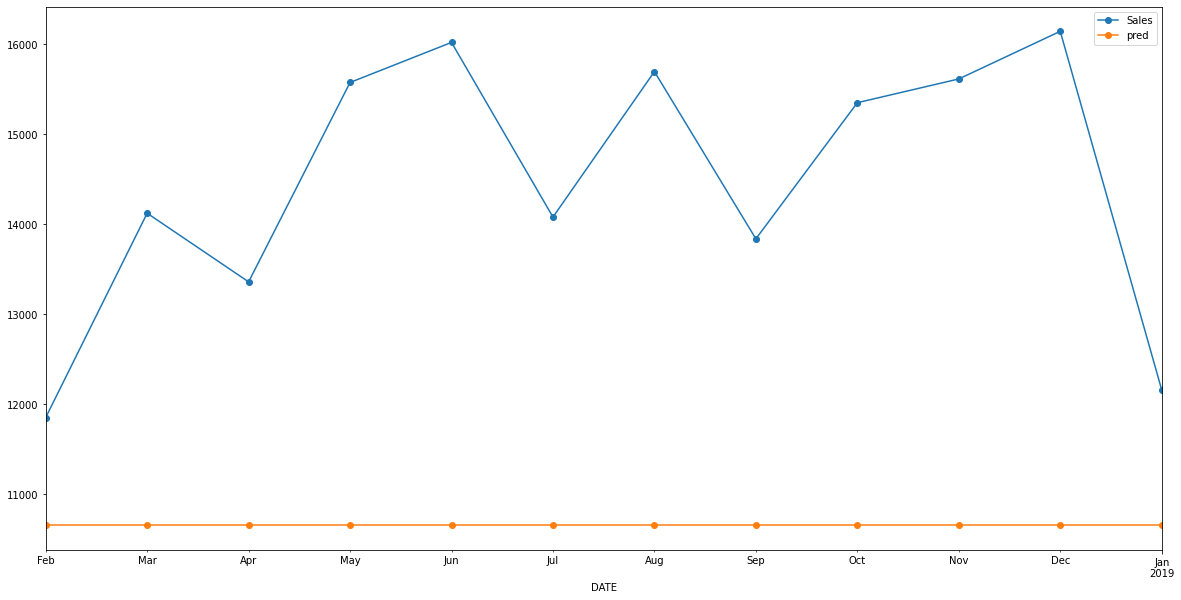

In [90]:
test_x['pred'] = train_x['Sales'].mean()

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Seasonal Naive

In [93]:
test_x.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

MAE : 839.08
RMSE : 1075.542
MAPE: 0.058


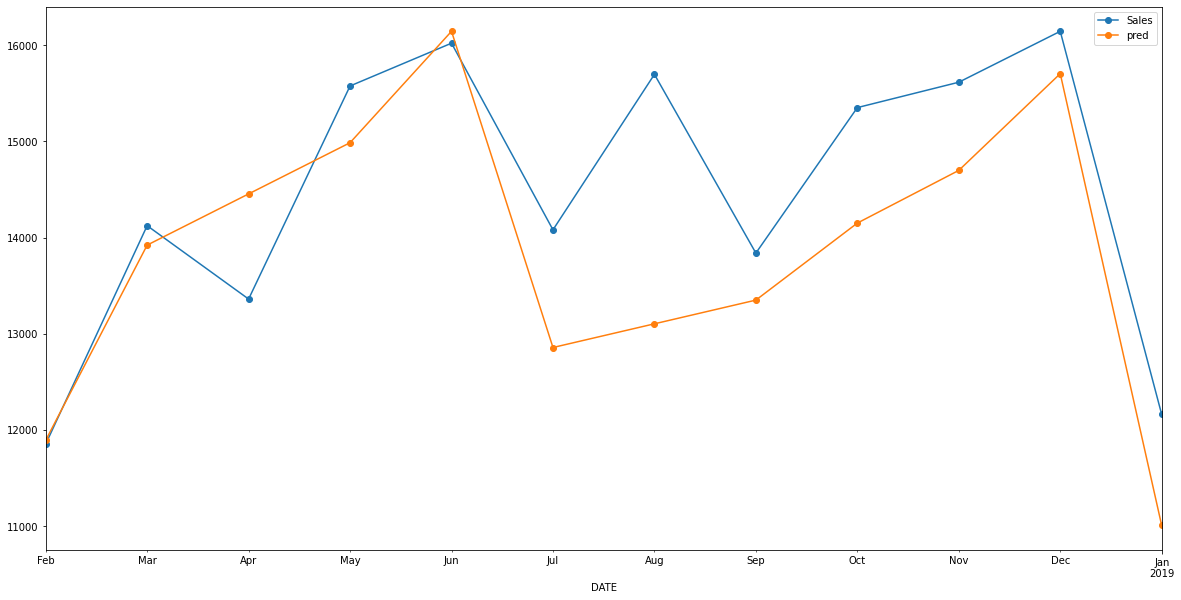

In [95]:
for i in test_x.index:
    test_x.loc[i]['pred'] = train_x.loc[i - pd.DateOffset(years=1)].Sales

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

### Drift Method

MAE : 3360.892
RMSE : 3640.673
MAPE: 0.224


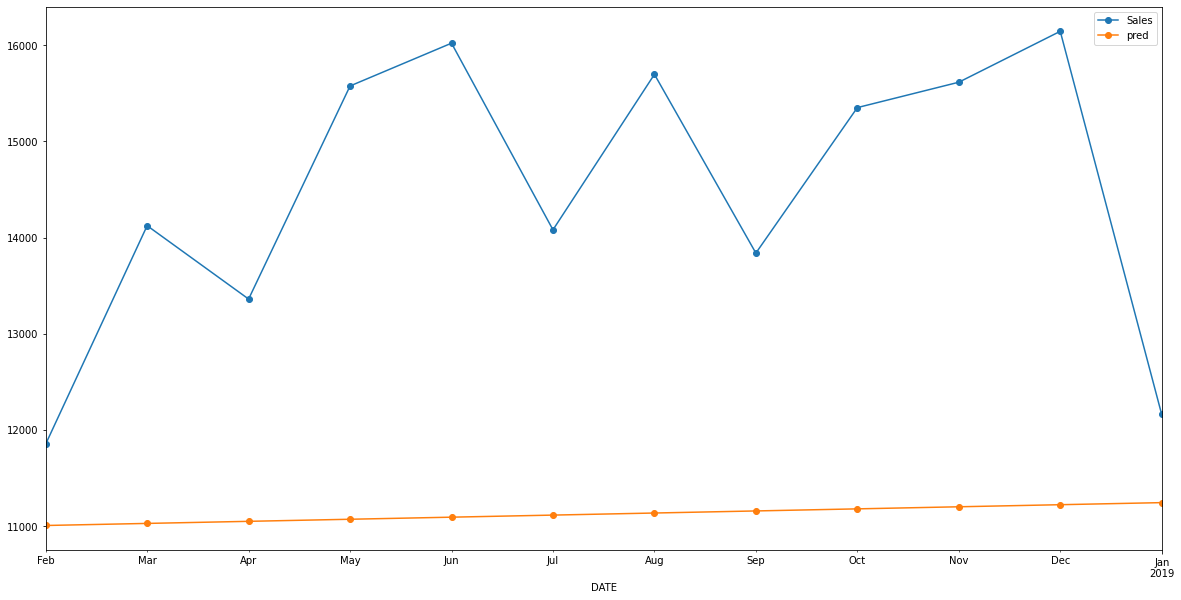

In [98]:
y_t = train_x['Sales'][-1]
y_0 = train_x['Sales'][0]

m = (y_t - y_0) / len(train_x['Sales'])
h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

### Moving Avg

In [114]:
pred_ = train_x.Sales.dropna().copy().values

for i in range(12):
    pred_ = np.append(pred_, pred_[-3:].mean())

In [115]:
pd.Series(pred_)

0       6573.360000
1       6654.000000
2       7332.000000
3       7332.000000
4       8240.000000
           ...     
212    13184.042219
213    13175.059036
214    13195.613236
215    13184.904830
216    13185.192368
Length: 217, dtype: float64

In [119]:
test_x['pred'] = pred_[-12:]

MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


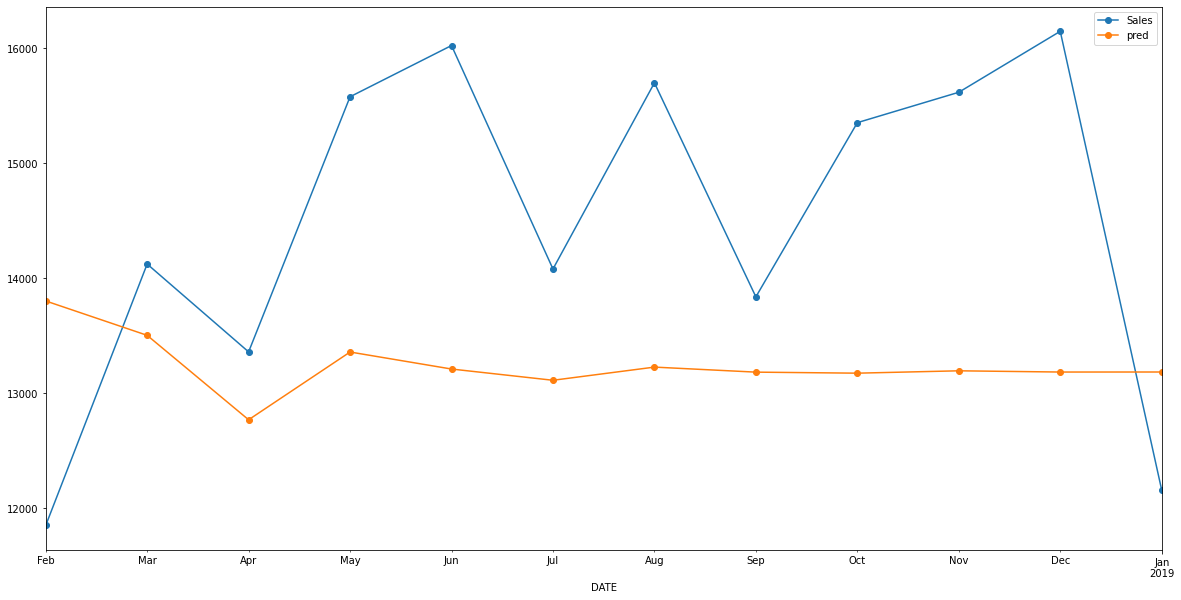

In [120]:
test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

## Smoothing Methods

In [121]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales)
_ = model.fit(smoothing_level = 0.8)
_.fittedvalues

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


DATE
2001-01-01     6617.987526
2001-02-01     6582.285505
2001-03-01     6639.657101
2001-04-01     7193.531420
2001-05-01     7304.306284
                  ...     
2018-09-01    15444.233816
2018-10-01    14159.246763
2018-11-01    15112.649353
2018-12-01    15514.529871
2019-01-01    16018.489974
Length: 217, dtype: float64

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


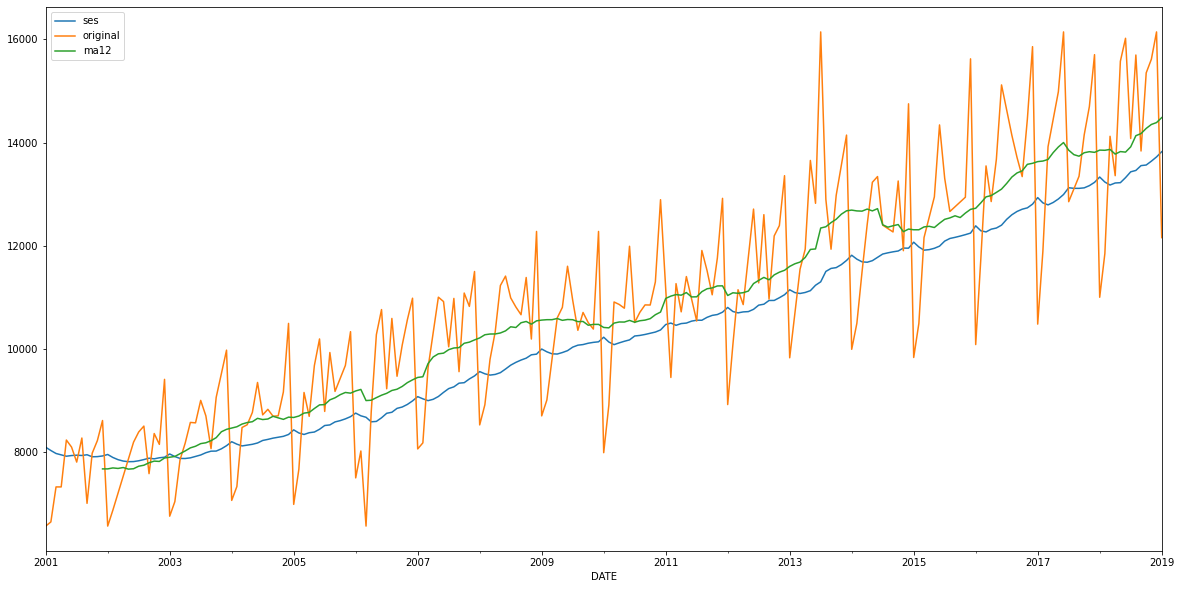

In [122]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12).mean().plot(label='ma12')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


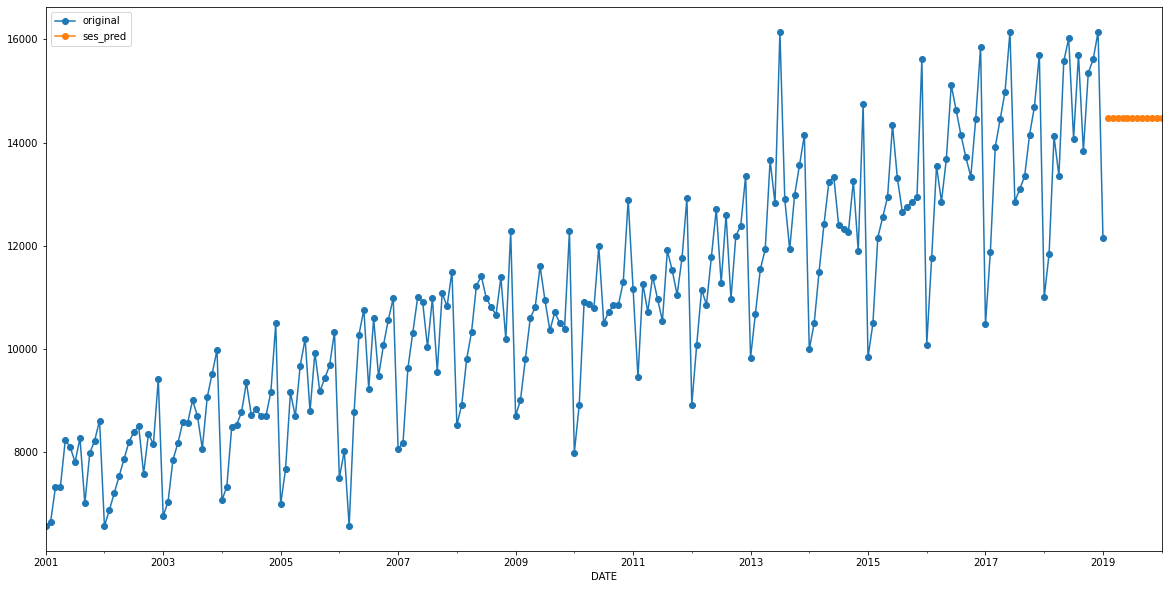

In [123]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.2)
pred = model.forecast(12)

mobile_sales.Sales.plot(label='original', style='-o')
pred.plot(label='ses_pred', style='-o')
plt.legend()

In [125]:
_ = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add')

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
_.fit()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


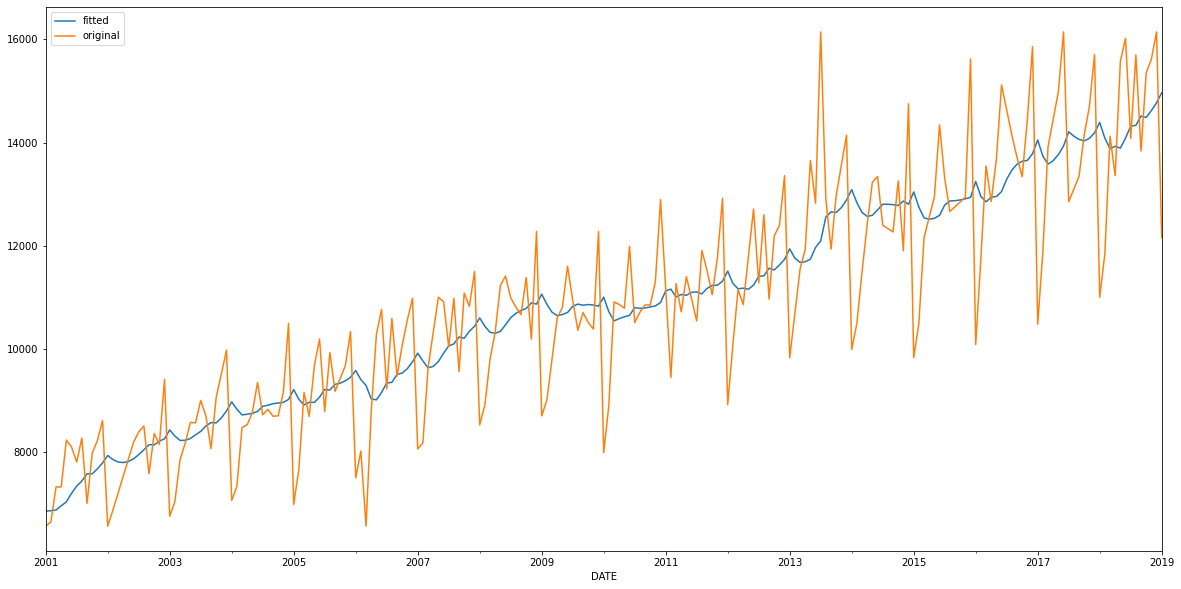

In [126]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit()
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

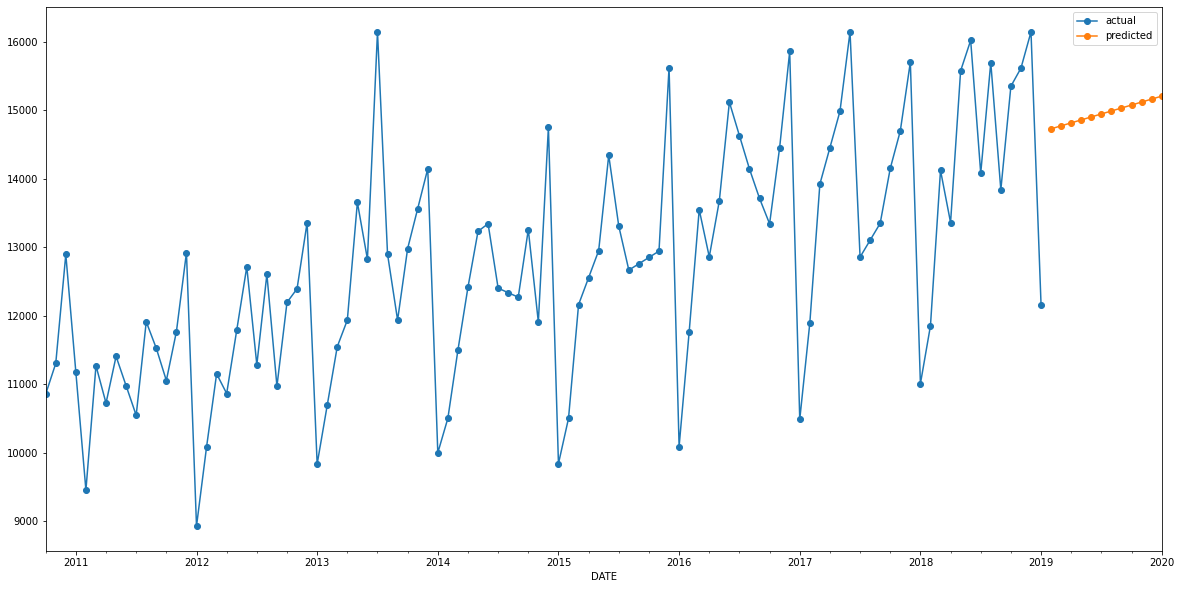

In [127]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


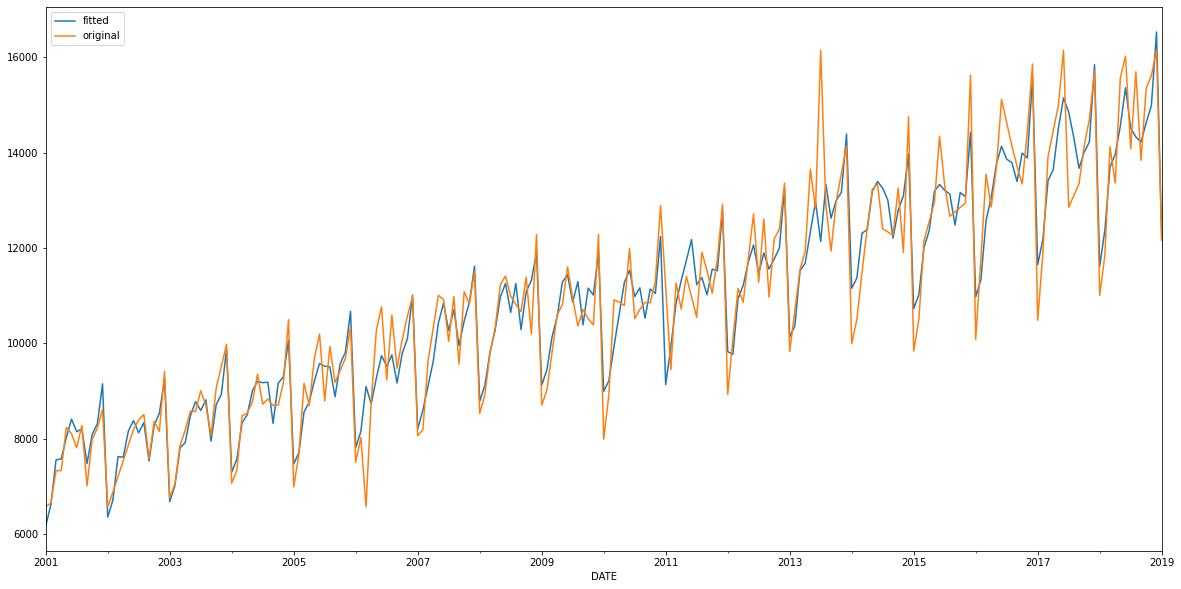

In [128]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit()
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

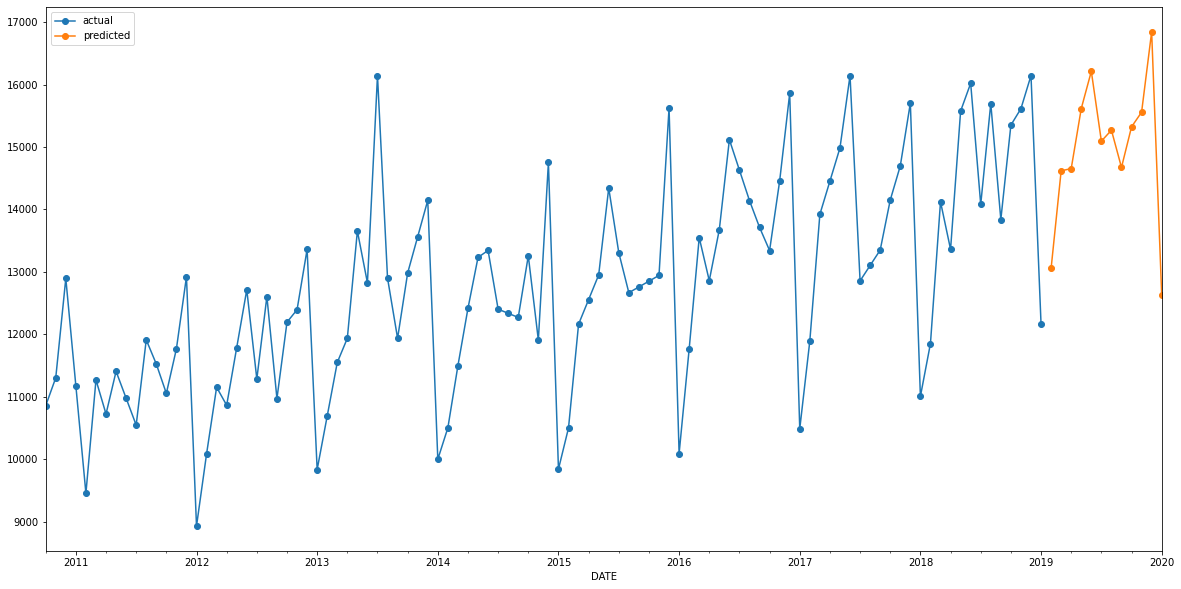

In [129]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

MAE : 525.172
RMSE : 558.083
MAPE: 0.036


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


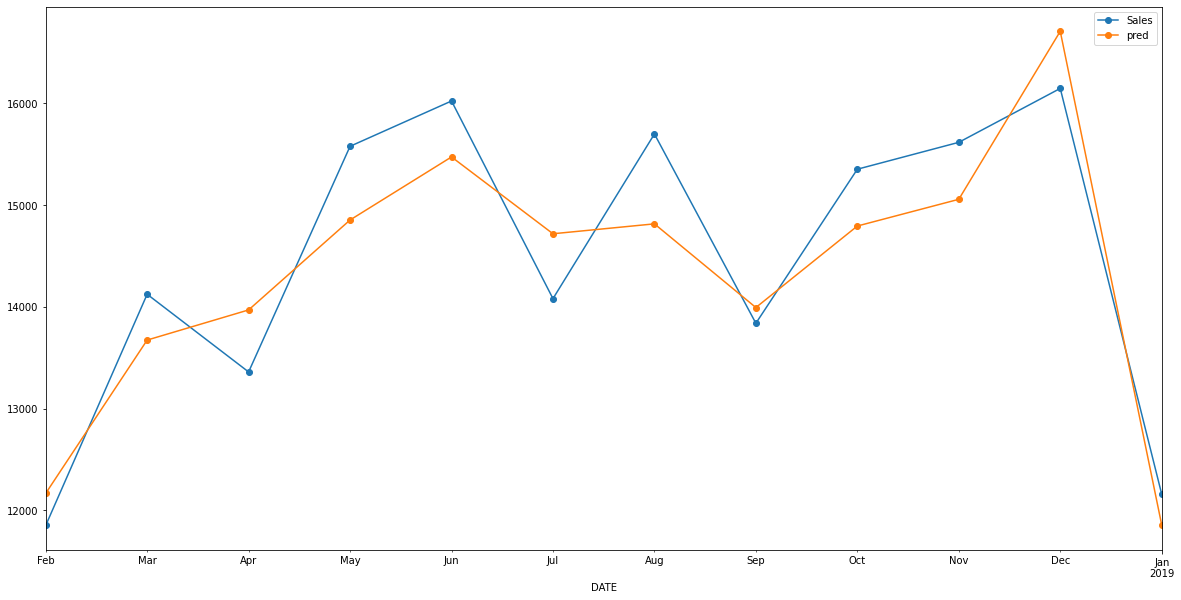

In [135]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='mul', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

<AxesSubplot:xlabel='DATE'>

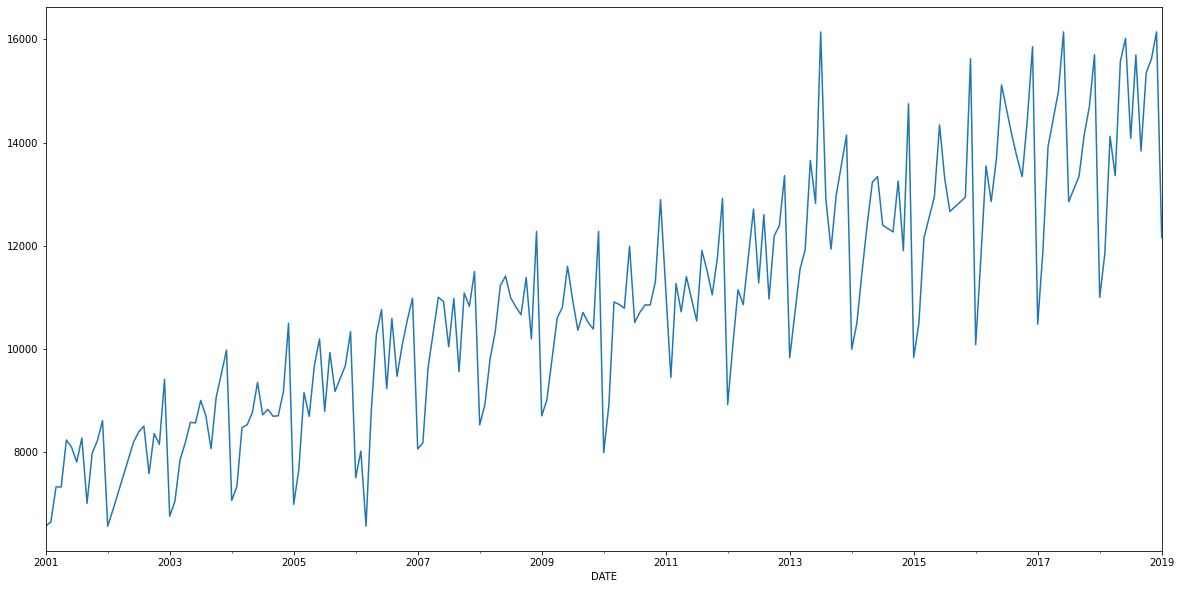

In [136]:
mobile_sales.Sales.plot()

### Dickey-Fuller test

In [138]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

0.9786335779042277

In [139]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

adf_test(mobile_sales.Sales)

Sequence is not stationary


In [140]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

<AxesSubplot:xlabel='DATE'>

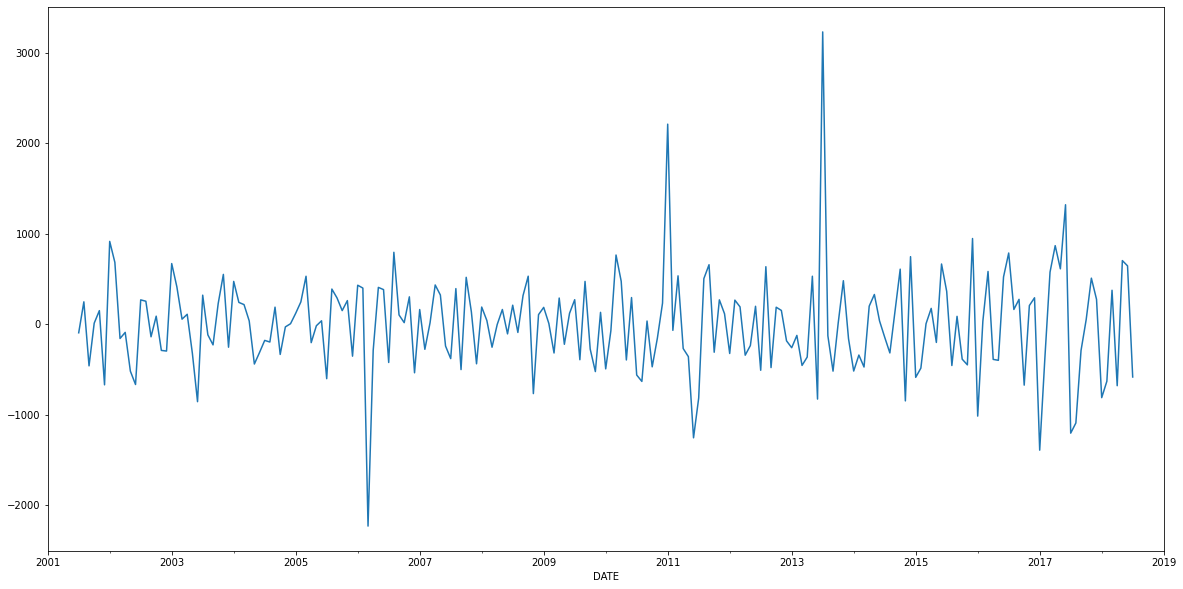

In [143]:
model.resid.plot()

In [145]:
adf_test(model.resid.dropna())

Sequence is stationary


<AxesSubplot:xlabel='DATE'>

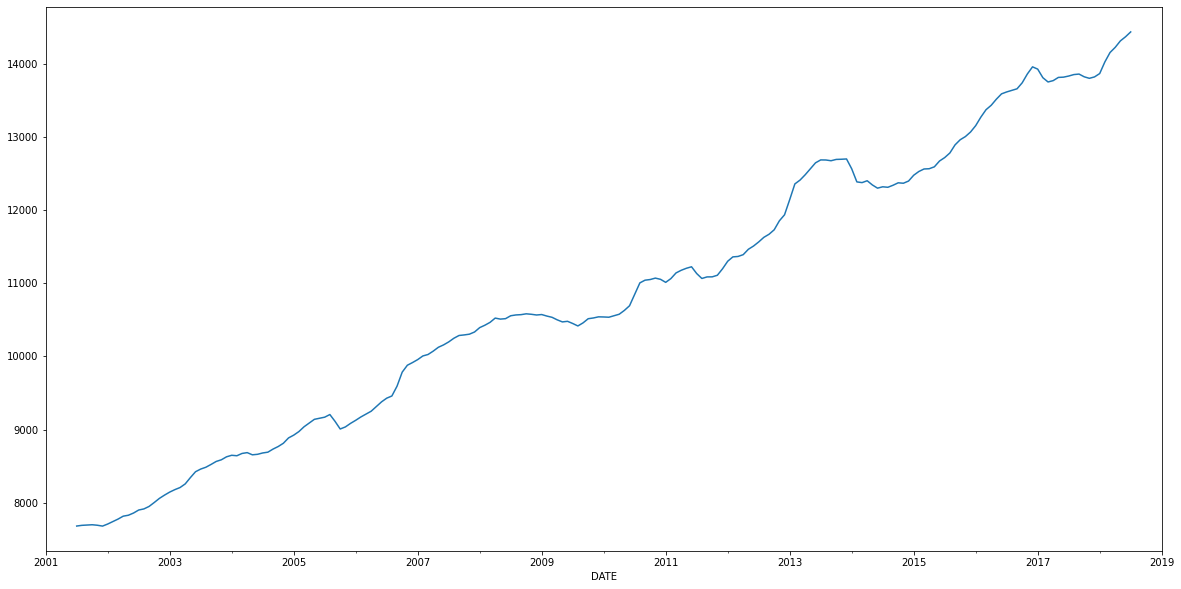

In [147]:
model.trend.plot()

<AxesSubplot:xlabel='DATE'>

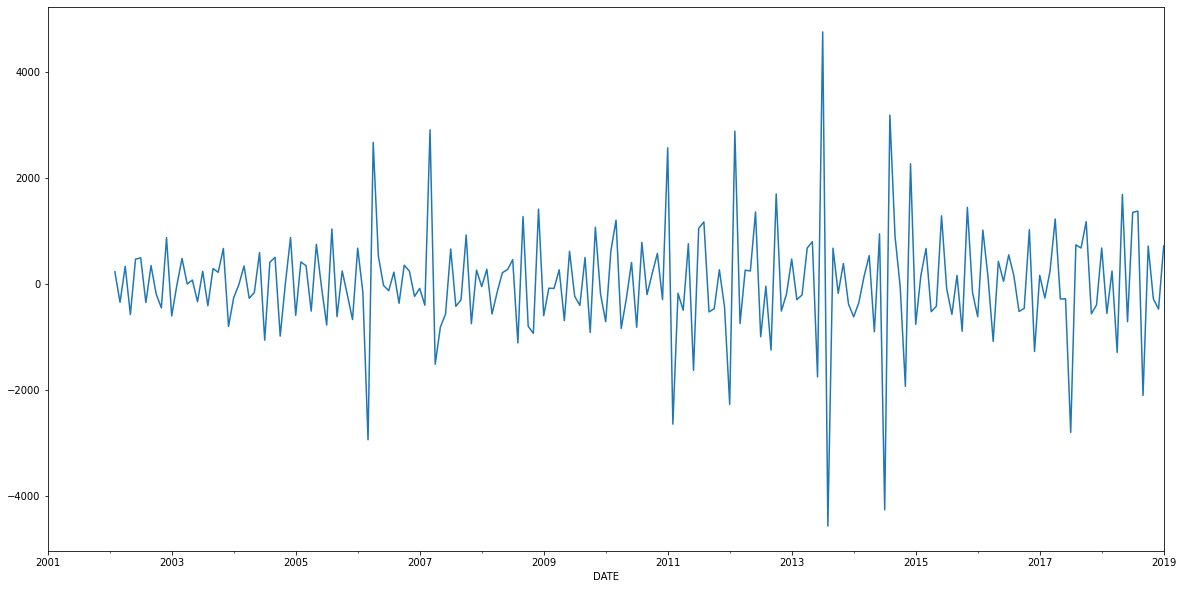

In [155]:
mobile_sales.Sales.diff(12).diff(1).plot()

In [156]:
adf_test(mobile_sales.Sales.diff(12).diff(1).dropna())

Sequence is stationary


In [158]:
mobile_sales.Sales

DATE
2001-01-01    6573.36
2001-02-01    6654.00
2001-03-01    7332.00
2001-04-01    7332.00
2001-05-01    8240.00
2001-06-01    8104.00
2001-07-01    7813.00
2001-08-01    8279.00
2001-09-01    7014.00
2001-10-01    7985.00
Name: Sales, dtype: float64

In [167]:
np.corrcoef(mobile_sales.Sales[1:], mobile_sales.Sales.shift(1).dropna())[0][1]

0.7974860661369779

<StemContainer object of 3 artists>

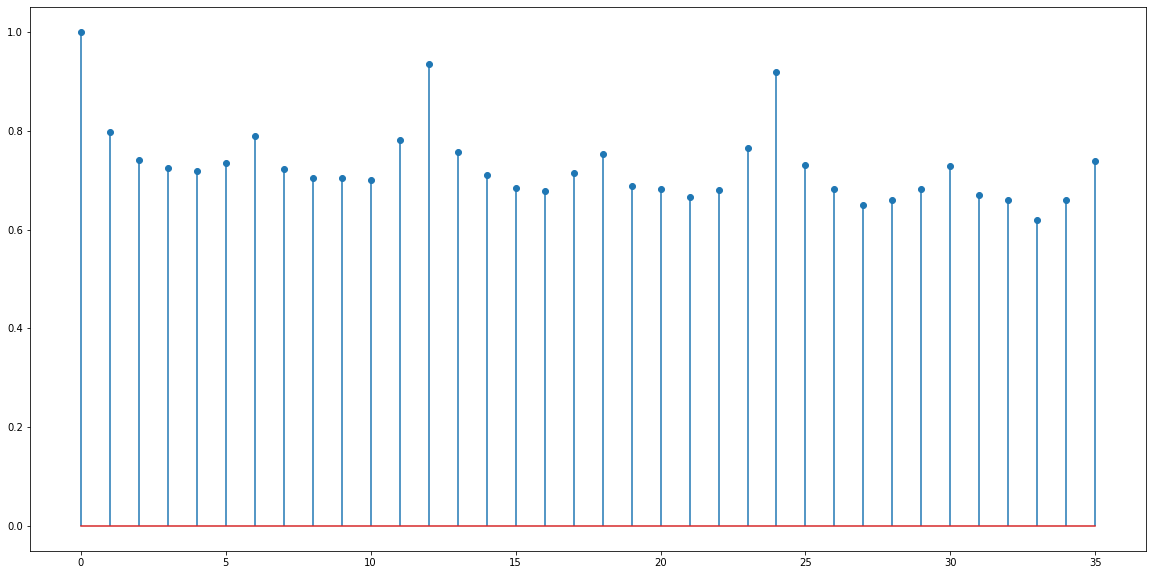

In [172]:
corr = []
for lag in range(36):
    corr.append(np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag).dropna())[0][1])

plt.stem(np.arange(36), corr)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


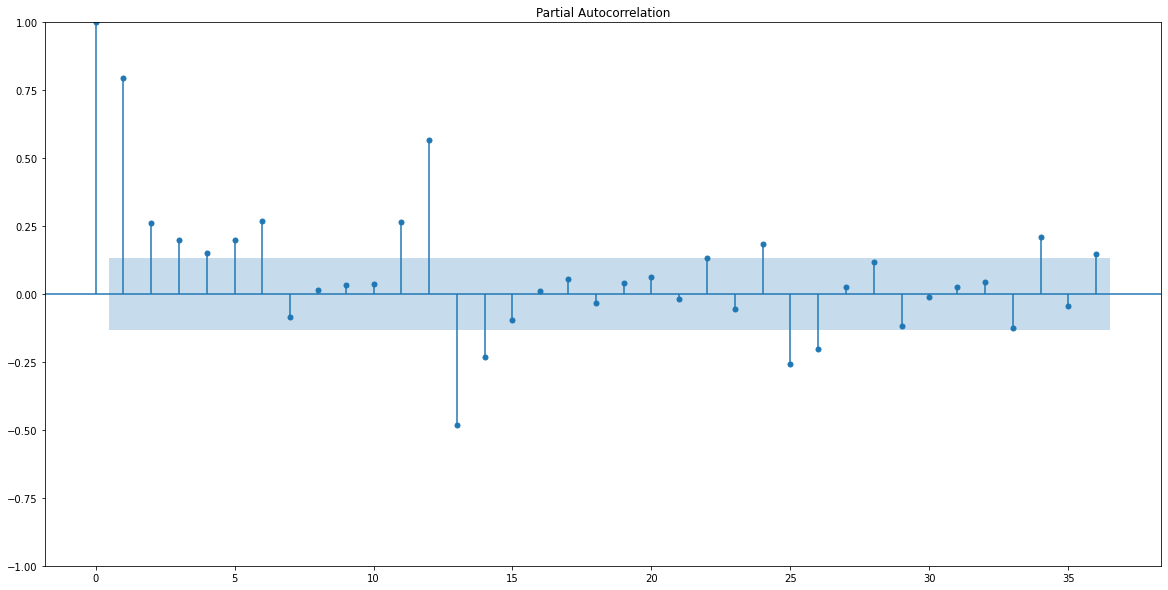

In [184]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_pacf(mobile_sales.Sales, lags=36);

--- 
# ARIMA FAMILY

In [189]:
train_x.head()

,Sales
DATE,
2001-01-01,6573.36
2001-02-01,6654.00
2001-03-01,7332.00
2001-04-01,7332.00
2001-05-01,8240.00


In [195]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [192]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


### AR(p)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE : 797.012
RMSE : 954.322
MAPE: 0.055


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


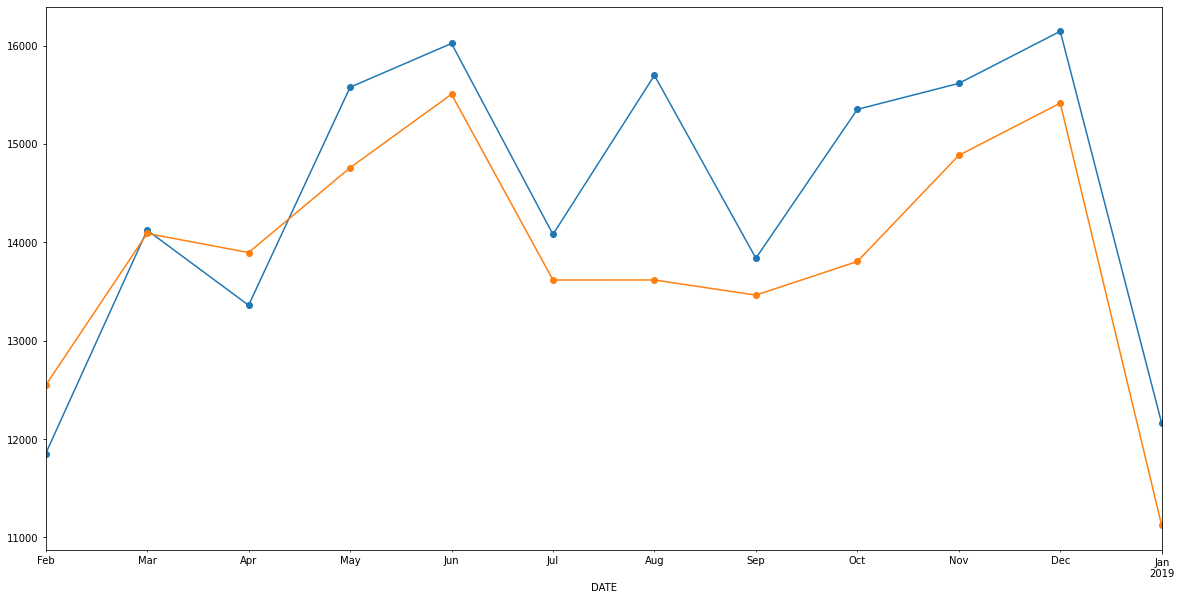

In [205]:
model = SARIMAX(train_x_st.Sales, order=(25, 0, 0)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x['Sales'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### MA(q)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 1169.732
RMSE : 1334.593
MAPE: 0.079


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


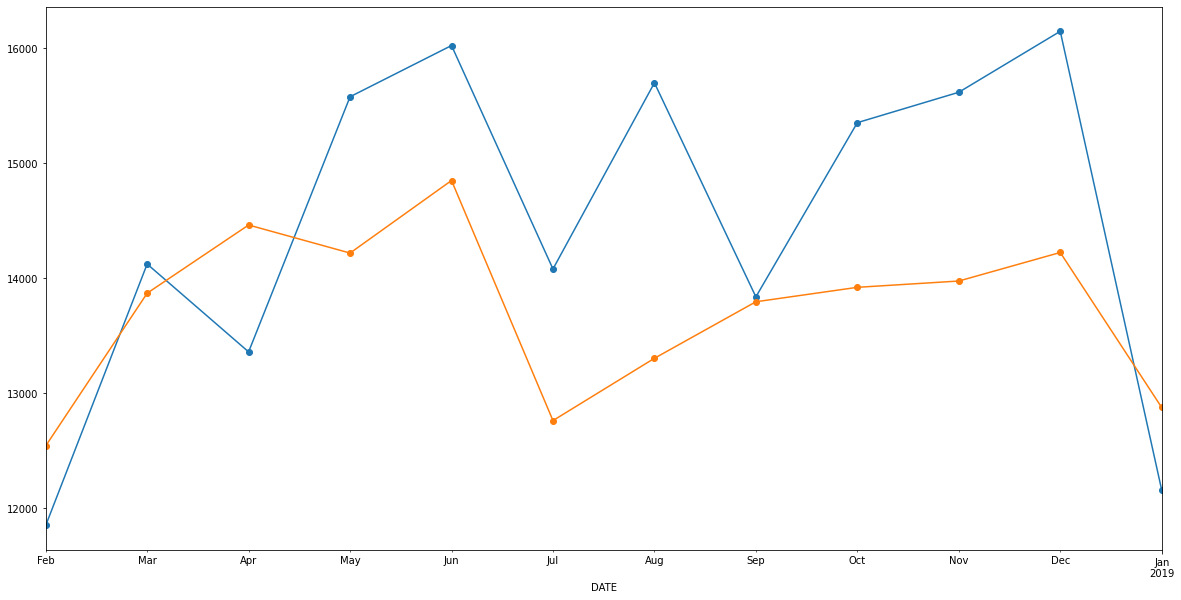

In [212]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 15)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x['Sales'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARMA(p, q)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Us

MAE : 651.647
RMSE : 786.14
MAPE: 0.046


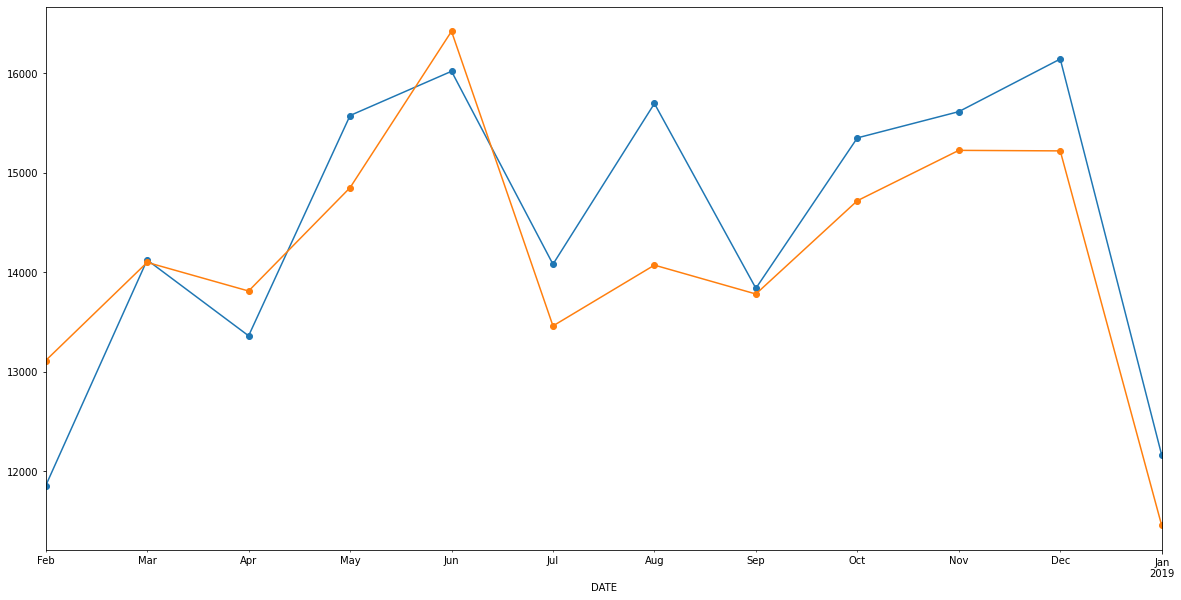

In [210]:
model = SARIMAX(train_x_st.Sales, order=(25, 0, 15)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x['Sales'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARIMA (p,d,q)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 1360.06
RMSE : 1608.725
MAPE: 0.091


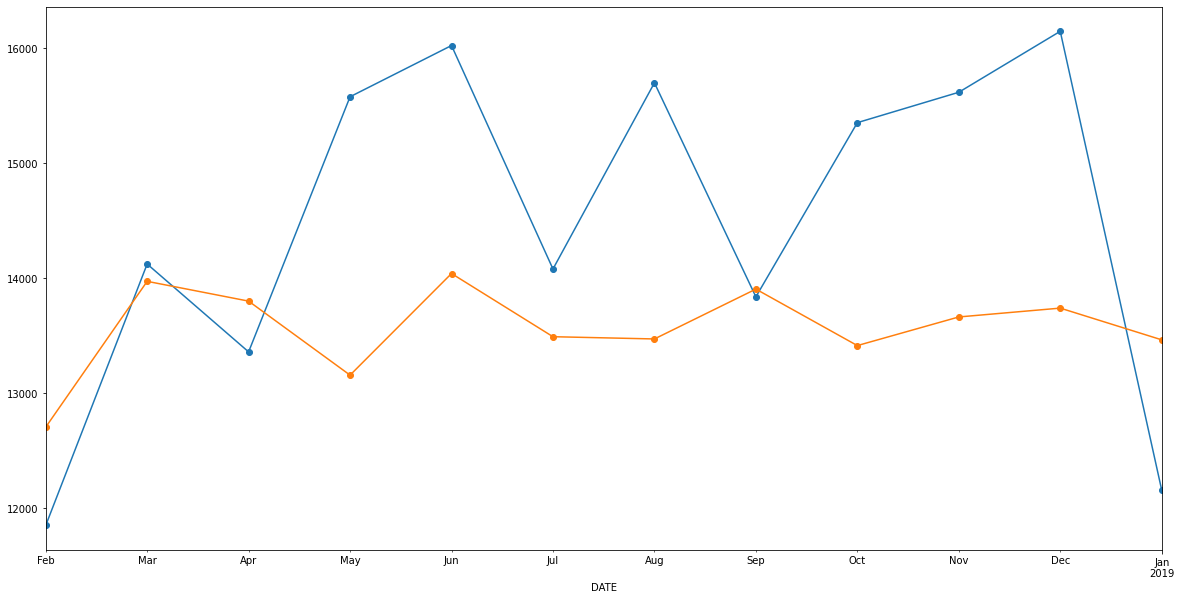

In [221]:
model = SARIMAX(train_x.Sales, order=(3, 1, 3)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

test_x['Sales'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### SARIMA (p,q,d,P,Q,D,s)

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 543.377
RMSE : 632.56
MAPE: 0.038


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


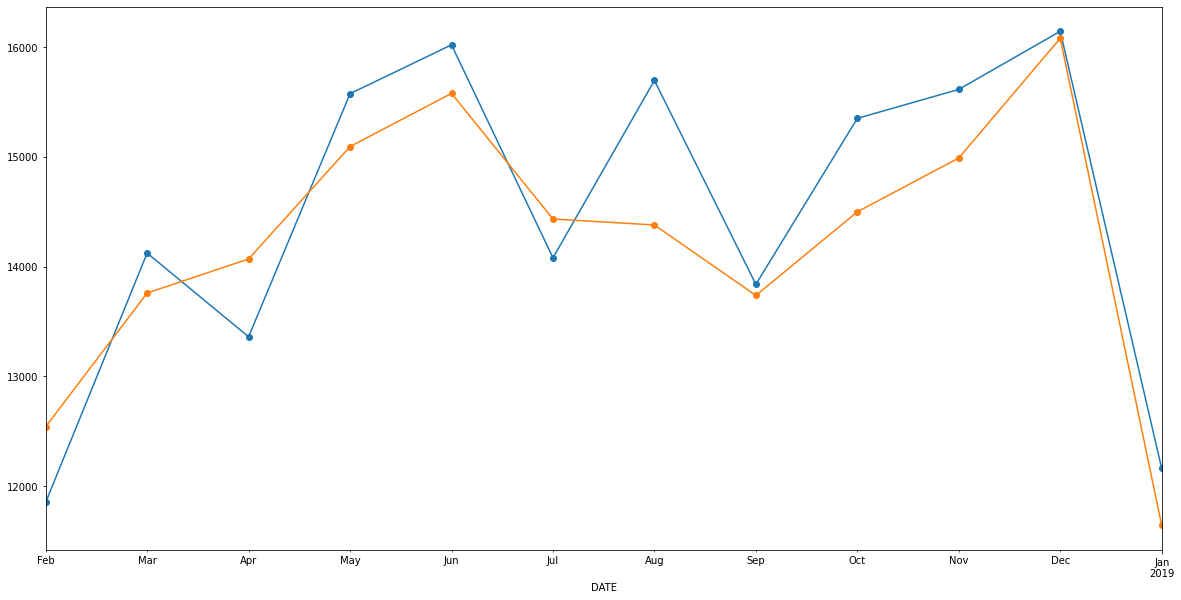

In [225]:
model = SARIMAX(train_x.Sales, order=(5, 1, 3), seasonal_order=(1,1,1,12)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

test_x['Sales'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['Sales'], test_x['pred'])